In [ ]:
import numpy as np
import pandas as pd
import numpy as np
# from cvxpy import *
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [ ]:
'''
数据下载用以因子计算+行情
'''

In [1]:
start_date = '2011-01-01' 
end_date = '2019-05-31'

m1 = M.instruments.v2(
    start_date=start_date,
    end_date=end_date,
    market='CN_STOCK_A',
    instrument_list=''
)

m7 = M.input_features.v1(
    features="""
beta_csi500_180_0
ta_mom_60_0
log(market_cap_0+0.0001)
west_eps_ftm_0/close_0
fs_net_income_0/market_cap_0
fs_eps_0/close_0
volatility_240_0
return_20
return_0
swing_volatility_240_0
fs_net_profit_qoq_0
fs_net_profit_yoy_0
fs_net_profit_0
west_netprofit_ftm_0
west_netprofit_ftm_0/market_cap_0
fs_operating_revenue_ttm_0/market_cap_0
fs_common_equity_0/market_cap_0
(fs_non_current_liabilities_0+market_cap_0)/market_cap_0
fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)
(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0
turn_0
"""
)

m8 = M.general_feature_extractor.v7(
    instruments=m1.data,
    features=m7.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m9 = M.derived_feature_extractor.v3(
    input_data=m8.data,
    features=m7.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)
 
# the material we need to build the factors are stored in Material DataFrame 
materials = m9.data.read_df()
materials = materials.set_index('date')

# materials.to_csv('D:/materialsStockData/materialsStockData.csv',index=True)

[2019-06-07 10:38:23.369353] INFO: bigquant: instruments.v2 开始运行..

[2019-06-07 10:38:23.429087] INFO: bigquant: 命中缓存

[2019-06-07 10:38:23.431766] INFO: bigquant: instruments.v2 运行完成[0.062429s].

[2019-06-07 10:38:23.436442] INFO: bigquant: input_features.v1 开始运行..

[2019-06-07 10:38:23.475291] INFO: bigquant: 命中缓存

[2019-06-07 10:38:23.477401] INFO: bigquant: input_features.v1 运行完成[0.040944s].

[2019-06-07 10:38:23.531060] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-06-07 10:38:23.570906] INFO: bigquant: 命中缓存

[2019-06-07 10:38:23.573536] INFO: bigquant: general_feature_extractor.v7 运行完成[0.042473s].

[2019-06-07 10:38:23.578068] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-06-07 10:38:23.618177] INFO: bigquant: 命中缓存

[2019-06-07 10:38:23.620400] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.042314s].

In [ ]:
'''
构建衍生因子
'''

In [2]:
# 构建十大类因子里面的所有小因子
# 流动性因子：stom,过去一个月日换手率之和的自然对数值;stoq,过去一个季度日换手率之和的自然对数值;stoa,过去一年日换手率之和的自然对数值
temporary_storage_dict = dict()
temporary_storage_dict['STOM'] = materials.groupby('instrument')['turn_0'].rolling(21).sum().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'turn_0':'STOM'})
temporary_storage_dict['STOQ'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(3).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOQ'})
temporary_storage_dict['STOA'] = temporary_storage_dict['STOM'].groupby('instrument').apply(lambda x:np.exp(x['STOM'])).rolling(12).mean().apply(lambda x:np.log(x)).reset_index().set_index('date').rename(columns={'STOM':'STOA'})

# 杠杆因子：mlev,市场杠杆,普通股市值+优先股账面值+长期负债账面值/普通股市值;dtoa,负债资产比;blev,账面杠杆,普通股账面值+优先股账面值+长期负债账面值/普通股账面值
temporary_storage_dict['MLEV'] = materials[['instrument','(fs_non_current_liabilities_0+market_cap_0)/market_cap_0']].rename(columns={'(fs_non_current_liabilities_0+market_cap_0)/market_cap_0':'MLEV'})
temporary_storage_dict['DTOA'] = materials[['instrument','fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)']].rename(columns={'fs_total_liability_0/(fs_current_assets_0+fs_non_current_assets_0)':'DTOA'})
temporary_storage_dict['BLEV'] = materials[['instrument','(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0']].rename(columns={'(fs_common_equity_0+fs_non_current_liabilities_0)/fs_common_equity_0':'BLEV'})

# 账面市值比因子：value,普通股账面值/普通股市值
temporary_storage_dict['Value'] = materials[['instrument','fs_common_equity_0/market_cap_0']].rename(columns={'fs_common_equity_0/market_cap_0':'Value'})

# 成长因子：growth,归母净利润同比增长率（有BUG,波动可能较大,估计不精确）
temporary_storage_dict['Growth'] = materials[['instrument','fs_net_profit_yoy_0']].rename(columns={'fs_net_profit_yoy_0':'Growth'})

# 盈利预期因子：epibs,cetop,分析师预期未来12月&历史12月盈利市值比;ETOP,历史12月现金流量市值比（有BUG）
temporary_storage_dict['EPIBS'] = materials[['instrument','west_eps_ftm_0/close_0']].rename(columns={'west_eps_ftm_0/close_0':'EPIBS'})
temporary_storage_dict['ETOP'] = materials[['instrument','fs_net_income_0/market_cap_0']].rename(columns={'fs_net_income_0/market_cap_0':'ETOP'})
temporary_storage_dict['CETOP'] = materials[['instrument','fs_eps_0/close_0']].rename(columns={'fs_eps_0/close_0':'CETOP'})

# 残差波动因子：dastd,过去12个月波动率;cmra,过去12个月对数超额收益率累加值序列的最大值减最小值;hsigma,CAPM模型过去12个月残差标准差（有BUG）
temporary_storage_dict['DASTD'] = materials[['instrument','volatility_240_0']].rename(columns={'volatility_240_0':'DASTD'})
temporary_storage_dict['GMRA'] = materials.groupby('instrument')['return_20'].rolling(12).apply(lambda x:np.log(1+np.max(x))-np.log(1+np.min(x))).reset_index().set_index('date').rename(columns={'return_20':'GMRA'})

# 市值因子：size,市值的自然对数
temporary_storage_dict['Size'] = materials[['instrument','log(market_cap_0+0.0001)']].rename(columns={'log(market_cap_0+0.0001)':'Size'})

# 动量因子：rstr,长期动量减去短期动量（有BUG）
temporary_storage_dict['Momentum'] = materials[['instrument','ta_mom_60_0']].rename(columns={'ta_mom_60_0':'Momentum'})

# 贝塔因子：beta,CAPM模型回归贝塔
temporary_storage_dict['Beta'] = materials[['instrument','beta_csi500_180_0']].rename(columns={'beta_csi500_180_0':'Beta'})

# 非线性市值 - 未构造完毕
temporary_storage_dict['Nlsize'] = temporary_storage_dict['Size'].copy().rename(columns={'Size':'Nlsize'})
temporary_storage_dict['Nlsize']['Nlsize'] = temporary_storage_dict['Size']['Size'].apply(lambda x: x**3)

In [3]:
instrument_list = list(set(materials['instrument'].tolist()))

In [4]:
# 因子:数据框 的字典拼接成一张表
for i in list(set(temporary_storage_dict.keys())):
    temporary_storage_dict[i] = temporary_storage_dict[i].reset_index()

initiate_factor_df  = temporary_storage_dict['STOM']  # 这里先取STOM因子数据
tmp_raw_factor_name = list(set(temporary_storage_dict.keys()).difference(['STOM']))
for i in tmp_raw_factor_name:
    initiate_factor_df = initiate_factor_df.merge(temporary_storage_dict[i], )

In [5]:
# 非线性市值 - 构造完毕
def Nlsize(df):
    tmp = df[['Size','Nlsize']]
    X = np.array(tmp[['Size']])
    y = tmp['Nlsize'].values
    reg = LinearRegression()
    try:
        reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
        res = y-reg.predict(X.reshape(-1, 1))
        df['Nlsize'] = res
    except ValueError as e:   
        df['Nlsize'] = np.nan
    return df
initiate_factor_df = initiate_factor_df.groupby('date').apply(Nlsize)

In [6]:
'''
去极值处理
'''

'\n去极值处理\n'

In [6]:
# 去极值处理（截面）
def winsorize(df):
    factors = set(df.columns).difference(['date', 'instrument'])
    for factor in factors:
        # 某个时间截面上全是NaN
        if df[df[factor].isnull()==True].shape[0] == len(df):
            continue
        median = np.median(df[factor])
        MAD = np.median(np.abs(df[factor] - median))
        df[factor][df[factor]>median+5*MAD] = median+5*MAD  # 盖帽处理偏离中位数5倍以上的数据
        df[factor][df[factor]<median-5*MAD] = median-5*MAD
    return df

# 截面数据去极值,返回日频因子数据
extrema_remove_df = initiate_factor_df.groupby('date').apply(winsorize)  

In [10]:
'''
数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理
'''

'\n数据转为月度,行业数据拼接,因子缺失值截面行业均值填充,行业、市值中性化处理和标准化处理\n'

In [7]:
# 读取行业数据和市值数据,并月度化
ins = list(extrema_remove_df.instrument.unique())
industry_info = D.history_data(ins, start_date, end_date, ['industry_sw_level1','market_cap_float'])   
industry_info['market_cap_float'] = np.log10(industry_info['market_cap_float'])  # 对市值因子取对数

industry_df = industry_info[(industry_info.industry_sw_level1!=0)&(industry_info.industry_sw_level1!=-1)].set_index('date')  # 取出其中有行业分类的条目，如果行业划分是0或者-1就算了，代表无划分

industry_df = industry_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  
industry_df.index = industry_df.index.droplevel(0)
industry_df.reset_index(inplace=True)

In [8]:
# 风格因子数据转换成月度,并与市值行业数据的拼接,并把行业因子转换成dummy数据 
extrema_remove_df.set_index('date', inplace=True)
extrema_remove_df = extrema_remove_df.groupby('instrument').apply(lambda x: x.resample('M', how='last'))  # pandas 处理时间序列数据，将原始数据转换为月末数据
extrema_remove_df.index = extrema_remove_df.index.droplevel(0) # 有多重index,丢弃股票代码index（来自groupby）
extrema_remove_df.reset_index(inplace=True)

extrema_remove_df = extrema_remove_df.merge(industry_df, on=['date', 'instrument']) # 风格因子数据和市值行业数据拼接

# 截面因子缺失值数据使用行业均值填充
extrema_remove_df = extrema_remove_df.groupby(['date', 'industry_sw_level1']).apply(lambda t: t.fillna(np.mean(t, axis=0)))
extrema_remove_df.reset_index(inplace=True, drop=True)

# 行业属性数据哑变量
dummy_industry_df = pd.get_dummies(extrema_remove_df['industry_sw_level1'], prefix='industry_prefix')   

# 哑变量与截面数据进行横向拼接
merge_df = pd.concat([extrema_remove_df, dummy_industry_df], axis=1).sort_values(['date', 'instrument'])  # 原始的行业因子那列应该还在

In [9]:
# 行业中性化处理和市值中性化处理 - 正交
def calcu_single_factor(df, factor):
    # 行业哑变量
    industry_factor = [i for i in df.columns if i[:15]=='industry_prefix']
    # 对市值因子和行业因子进行回归
    xvars = ['market_cap_float'] + industry_factor
    used_factors = xvars + [factor] + ['instrument']
    
    used_factors_df = df[used_factors]
    used_factors_df = used_factors_df[~used_factors_df.isnull().T.any().T]
    if len(used_factors_df) == 0:
        return None
    X = used_factors_df[xvars]
    y = used_factors_df[factor]
    reg = LinearRegression()
    try:
        reg.fit(X,y)   # 将行业因子因子和市值因子对特定因子作回归
        res = y-reg.predict(X)
        used_factors_df[factor] = res
    except ValueError as e:
        used_factors_df[factor] = np.nan 

    return used_factors_df[['instrument',factor]]

detail_style_factor = [m for m in initiate_factor_df.columns if m not in ['date','instrument','market_cap_float']]  

# 对风格因子进行市值中性化处理,共计16个风格因子
# 对每个因子,在时间截面上处理
factor_data_after_neutralize = pd.DataFrame(columns=['date','instrument'])
for factor in detail_style_factor: 
    result_temp = merge_df.groupby('date').apply(lambda x: calcu_single_factor(x, factor)).reset_index().drop('level_1',axis=1)
    factor_data_after_neutralize = factor_data_after_neutralize.merge(result_temp, on=['date', 'instrument'], how='outer') # 因为是拼接,每次都取并集,第一次相当于填充

# 标准化处理
def standardlize(x):
    return (x-x.mean())/x.std()
for factor in detail_style_factor:
    factor_data_after_neutralize[factor] = factor_data_after_neutralize.groupby('date')[factor].apply(standardlize)

# 用0值填充标准化后的缺失值 
factor_data_after_standard = factor_data_after_neutralize.fillna(0)

In [15]:
'''
获取股票价格数据
'''

'\n获取股票价格数据\n'

In [10]:
# 获取股票价格并月度化 - 从已经构造好的因子数据集获取时间以及标的信息
start = factor_data_after_standard.date.min().strftime('%Y-%m-%d')   
end = factor_data_after_standard.date.max().strftime('%Y-%m-%d')      
ins = list(set(factor_data_after_standard.instrument))    

price = DataSource('bar1d_CN_STOCK_A').read(instrument=ins, start_date=start, end_date=end, fields=['close'])    
price.rename(columns={'close':'price'}, inplace=True)
price = price.set_index('date').groupby('instrument').apply(lambda x: x.resample('M', how='last'))    
price.index = price.index.droplevel(0)
price.reset_index(inplace=True)

In [17]:
'''
数据透视表计算股票收益率与因子数据合并
'''

'\n数据透视表计算股票收益率与因子数据合并\n'

In [11]:
# 通过价格计算收益率并合成大类风格因子
tmp_factor = [m for m in merge_df.columns if m not in ['market_cap_float','industry_sw_level1']]
industry_prefix_factor = list(set(tmp_factor).difference(set(detail_style_factor)))  # industry_prefix_factor  是date instrument 和行业因子,共计30个因子

# 构建一个总的数据表, 合并行业因子和价格
monthly_style_and_industry_factor = factor_data_after_standard.merge(price, on=['date', 'instrument'], how='inner')
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(merge_df[industry_prefix_factor], on=['date', 'instrument'], how='inner').set_index('date')  

# 计算出收益率 - 需要注意,月度收益率若为T~T+1期的收益,则标记时间为T,因为与因子对应的收益率数据是下一期收益
monthly_style_and_industry_factor.reset_index(inplace=True)

monthly_price_df = monthly_style_and_industry_factor.pivot_table(values='price',columns='instrument',index='date')
# monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
#                               ).to_frame('return').reset_index(),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.merge(monthly_price_df.pct_change().shift(-1).unstack(
                              ).reset_index().rename(columns={0:'return'}),on=['date','instrument']) # 这里的shift(-1)很关键
monthly_style_and_industry_factor = monthly_style_and_industry_factor.dropna()

In [93]:
print(merge_df.columns,'\n')
print(factor_data_after_standard.columns)

Index(['date', 'instrument', 'STOM', 'Size', 'Beta', 'GMRA', 'Growth', 'BLEV',
       'STOQ', 'Momentum', 'ETOP', 'DTOA', 'DASTD', 'MLEV', 'Value', 'EPIBS',
       'STOA', 'CETOP', 'industry_sw_level1', 'market_cap_float',
       'industry_prefix_110000', 'industry_prefix_210000',
       'industry_prefix_220000', 'industry_prefix_230000',
       'industry_prefix_240000', 'industry_prefix_270000',
       'industry_prefix_280000', 'industry_prefix_330000',
       'industry_prefix_340000', 'industry_prefix_350000',
       'industry_prefix_360000', 'industry_prefix_370000',
       'industry_prefix_410000', 'industry_prefix_420000',
       'industry_prefix_430000', 'industry_prefix_450000',
       'industry_prefix_460000', 'industry_prefix_480000',
       'industry_prefix_490000', 'industry_prefix_510000',
       'industry_prefix_610000', 'industry_prefix_620000',
       'industry_prefix_630000', 'industry_prefix_640000',
       'industry_prefix_650000', 'industry_prefix_710000',
       'in

In [ ]:
'''
小类因子合并为大类因子 - 比较灵活
'''

In [12]:
# 小因子等权重合并成大因子, 这里未来可以采取IC_IR法
monthly_style_and_industry_factor['Volatility'] = (monthly_style_and_industry_factor['DASTD']+monthly_style_and_industry_factor['GMRA'])/2
# monthly_style_and_industry_factor['Volatility'] = monthly_style_and_industry_factor['dastd']
monthly_style_and_industry_factor['EarningYields'] = (monthly_style_and_industry_factor['EPIBS']+monthly_style_and_industry_factor['ETOP']+monthly_style_and_industry_factor['CETOP'])/3
monthly_style_and_industry_factor['Leverage'] = (monthly_style_and_industry_factor['MLEV']+monthly_style_and_industry_factor['BLEV']+monthly_style_and_industry_factor['DTOA'])/3
monthly_style_and_industry_factor['Liquidity'] = (monthly_style_and_industry_factor['STOM']+monthly_style_and_industry_factor['STOQ']+monthly_style_and_industry_factor['STOA'])/3
monthly_style_and_industry_factor.drop(['DASTD','GMRA','EPIBS','ETOP','CETOP','MLEV','BLEV','DTOA','STOM','STOQ','STOA'], axis=1, inplace=True)

In [58]:
monthly_style_and_industry_factor.columns

Index(['date', 'instrument', 'STOM', 'MLEV', 'Size', 'Momentum', 'EPIBS',
       'GMRA', 'ETOP', 'Nlsize', 'Beta', 'BLEV', 'dastd', 'Value', 'CETOP',
       'STOA', 'STOQ', 'Growth', 'DTOA', 'DASTD', 'price',
       'industry_prefix_490000', 'industry_prefix_710000',
       'industry_prefix_420000', 'industry_prefix_620000',
       'industry_prefix_430000', 'industry_prefix_510000',
       'industry_prefix_240000', 'industry_prefix_350000',
       'industry_prefix_370000', 'industry_prefix_460000',
       'industry_prefix_480000', 'industry_prefix_230000',
       'industry_prefix_450000', 'industry_prefix_110000',
       'industry_prefix_730000', 'industry_prefix_270000',
       'industry_prefix_410000', 'industry_prefix_640000',
       'industry_prefix_220000', 'industry_prefix_650000',
       'industry_prefix_210000', 'industry_prefix_360000',
       'industry_prefix_720000', 'industry_prefix_610000',
       'industry_prefix_340000', 'industry_prefix_330000',
       'industry_prefix_

In [ ]:
'''
计算股票特质收益率
'''

In [13]:
style_factor = ['Value','Growth','Size','Beta','Momentum','Volatility','EarningYields','Leverage','Liquidity','Nlsize']

In [ ]:
'''
月度选股类模型回测函数
- 行情数据(至少为包含收盘价的日度数据)
- 选股用数据(日度或月度均可)
'''

In [69]:
# 初始化变量

# 初始资金
capital_base = 10000000
# 现金
cash = 10000000
# 当前净值
current_equity = 10000000
# 仓位上限
position_upper = 0.8
# 交易成本
cost_ratio = 0.003
# 当前持仓 - 股票型,只有多头,key为股票代码,value为具体金额
current_position = dict()
# 净值历史记录(用于绘图),记录日期以及净值,日度
history_position = dict()
equity_df = pd.DataFrame()
# 持仓历史记录(用于绘图),记录日期以及持仓情况,月度
history_order = dict()
# 基本数据 - 行情数据
trade_data = materials[['return_0','instrument','close_0']].rename(columns = {'close_0':'close','return_0':'return'}).reset_index()
strategy_data = monthly_style_and_industry_factor.copy()
# 基本数据 - 策略运行日期,月度
strategy_day = np.sort(strategy_data['date'].unique())
# 策略运行次数计数器
run_cnt = 0

In [122]:
def clear_function(df1,df2,value1,dict1,day1,day2,value2):
    '''
    结算函数
    输入行情数据df1,原净值df2,原当前净值value1,原当前仓位dict1,上月末day1,本月末day2
    根据当前持仓获取本期净值序列
    更新净值df2、当前净值value1、当前仓位dict1,df2最后一个值需要更新
    '''
    trade_data_period = df1[(df1['date']<=day2) & (df1['date']>=day1)].copy()
    current_stock_list = list(current_position.keys())
    current_stock_value = [current_position[stock] for stock in current_stock_list]
    trade_data_period_stock = trade_data_period[trade_data_period['instrument'].isin(current_stock_list)]
    # 获取计算组合内个股价值序列的算子
    value_operator_df = trade_data_period_stock.pivot_table(index='date',columns='instrument',values='close').pct_change().apply(lambda x: np.log(1+x)).fillna(0).expanding().sum().apply(lambda x: np.exp(x))
    # 算子乘以个股初始价值得到价值序列
    stock_value_df = value_operator_df.copy()
    for stock in current_stock_list:
        stock_value_df[stock] = value_operator_df[stock].apply(lambda x: x*current_position[stock])
        dict1[stock] = stock_value_df[stock].tolist()[-1]
    # 个股价值序列相加得到组合价值序列,再加现金得到净值序列
    df2 = pd.concat([df2,(stock_value_df.sum(axis=1).to_frame('stock_portfolio_value')+value2).iloc[1::,]],axis=0)
    # 更新当前净值,用以计算目标仓位
    value1 = df2.iloc[-1,].values[0]
    return df2,value1,dict1

In [146]:
def strategy_function(day1,df1,value1,factor):
    '''
    策略函数
    输入每个月末的日期day1,即策略运行时间点,输入策略所需全集df1,输入当前净值value1
    经过选股策略
    输出目标仓位expect_position,字典
    '''
    # 截取策略所需数据,必然是<=strategy_day_used的子集
    strategy_data_used = df1[df1['date'] == day1].copy()
    
    # 月度因子选股策略1 - 低流动性股票
    dict1 = {}
    expect_stock_list = strategy_data_used.sort_values(factor).head(50)['instrument'].unique().tolist()
    for stock in expect_stock_list:
        dict1[stock] = value1*position_upper/len(expect_stock_list)
    return dict1

In [124]:
def trade_function(dict1,dict2,day1,df1,value1,dict3):
    '''
    交易函数
    输入目标仓位expect_position dict1,当前仓位current_position dict2,策略运行当日day1,历史净值df1,原现金value1,原历史仓位dict3
    将目前仓位调整至目标仓位
    更新cash、current_position、history_position、净值df1最后一行(减成本)
    '''
    tmp_sell = dict2
    tmp_buy = dict1
    current_stock_list = list(tmp_sell.keys())
    expect_stock_list = list(tmp_buy.keys())
    inter_stock = [stock for stock in expect_stock_list if stock in current_stock_list]
    for stock in inter_stock:
        change = tmp_buy[stock] - tmp_sell[stock]
        # 原有的需要新增买入
        if change >=0:
            tmp_buy[stock] = change
            tmp_sell[stock] = 0
        # 原有的需要部分卖出
        else:
            tmp_sell[stock] = -change
            tmp_buy[stock] = 0
    # 至此tmp_buy是买入指令单,tmp_sell是卖出指令单 - 目前是一样操作
    cost = 0
    for stock in tmp_sell.keys():
        cost += tmp_sell[stock]*cost_ratio
    for stock in tmp_buy.keys():
        cost += tmp_buy[stock]*cost_ratio
    sell_stock = [stock for stock in current_stock_list if stock not in inter_stock]
    buy_stock = [stock for stock in expect_stock_list if stock not in inter_stock]
    
    # 更新部分
    # 更新最后一天交易前的净值,扣除成本
    if run_cnt == 0:
        df1['date'] = [day1]
        df1['stock_portfolio_value'] = [value1 - cost]
        df1 = df1.set_index('date')
    else:
        df1.iloc[-1,] -= cost
    # 净值减去股票价值得到新的现金数量
    value1 = df1.iloc[-1,].values[0] - sum([dict1[stock] for stock in dict1.keys()])
    # 新的当前仓位即目标仓位
    dict4 = dict1
    # 更新历史仓位
    if 'date' not in dict3.keys():
        dict3['date'] = []
    if 'history_position' not in dict3.keys():
        dict3['history_position'] = []
    dict3['date'].append(day1)
    dict3['history_position'].append(dict4)
    
    return df1, value1, dict4, dict3

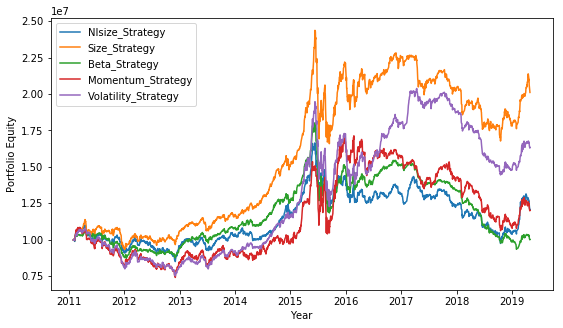

           max_drawdown cumulative_return avg_annual_return  \
Nlsize         0.415076          0.206118         0.0263663   
Size           0.319411           1.01076          0.129295   
Beta           0.482152        0.00087556       0.000112001   
Momentum       0.380212          0.199484         0.0255177   
Volatility     0.370141          0.632858         0.0809544   

           return_drawdown_ratio  
Nlsize                  0.496578  
Size                     3.16445  
Beta                  0.00181594  
Momentum                0.524665  
Volatility               1.70978  


In [155]:
# 策略运行,多个单因子策略
plt.figure(figsize=(9, 5))
factor_choosen = ['Nlsize','Size','Beta','Momentum','Volatility']
index_df = pd.DataFrame(columns=['max_drawdown','cumulative_return','avg_annual_return','return_drawdown_ratio'],index=factor_choosen)
for factor in factor_choosen: 
    
    ###### 回测模块-起点 ######
    
    # 初始化变量
    # 初始资金
    capital_base = 10000000
    # 现金
    cash = 10000000
    # 当前净值
    current_equity = 10000000
    # 仓位上限
    position_upper = 0.8
    # 交易成本
    cost_ratio = 0.003
    # 当前持仓 - 股票型,只有多头,key为股票代码,value为具体金额
    current_position = dict()
    # 净值历史记录(用于绘图),记录日期以及净值,日度
    equity_df = pd.DataFrame()
    # 持仓历史记录(用于绘图),记录日期以及持仓情况,月度
    history_position = dict()
    # 基本数据 - 行情数据
    trade_data = materials[['return_0','instrument','close_0']].rename(columns = {'close_0':'close','return_0':'return'}).reset_index()
    strategy_data = monthly_style_and_industry_factor.copy()
    # 基本数据 - 策略运行日期,月度
    strategy_day = np.sort(strategy_data['date'].unique())
    # 策略运行次数计数器
    run_cnt
    
    for run_cnt in range(len(strategy_day)):

        each_strategy_day = strategy_day[run_cnt]

        if run_cnt == 0:
            # 清算,第一天运行策略无需清算
            pass
            # 策略,输入日期,策略所需数据,当前净值 -> 得到期望仓位 (输入中的最后一项用以计算期望仓位中的价值)
            expect_position = strategy_function(each_strategy_day,strategy_data,current_equity,factor)
            # 交易,将当前仓位调整至目标仓位,输入期望仓位,当前仓位,交易日,净值df,现金,历史持仓 -> 更新净值df最后一行(减去成本),更新剩余现金,更新当前仓位,更新历史持仓
            equity_df, cash, current_position, history_position = trade_function(expect_position,current_position,each_strategy_day,equity_df,cash,history_position)
        else:
            last_each_strategy_day = strategy_day[run_cnt-1]
            # 清算,输入行情数据,净值df,当前净值,当前仓位,现金 -> 更新净值df,当前净值,当前仓位 (输出中的倒数1、2项是因为股票价值在一月中发生变化,输入中的最后一项因为净值需要加上新的cash)
            equity_df,current_equity,current_position = clear_function(trade_data,equity_df,current_equity,current_position,last_each_strategy_day,each_strategy_day,cash)
            # 策略,输入日期,策略所需数据,当前净值 -> 得到期望仓位 (输入中的最后一项用以计算期望仓位中的价值)
            expect_position = strategy_function(each_strategy_day,strategy_data,current_equity,factor)
            # 交易,将当前仓位调整至目标仓位,输入期望仓位,当前仓位,交易日,净值df,现金,历史持仓 -> 更新净值df最后一行(减去成本),更新剩余现金,更新当前仓位,更新历史持仓
            equity_df, cash, current_position, history_position = trade_function(expect_position,current_position,each_strategy_day,equity_df,cash,history_position)

        run_cnt += 1
    
    ###### 回测模块-终点 ######
    
    ## 绘图 ##
    name = factor + '_Strategy'
    plt.plot(equity_df,label = name)
    
    ## 评价指标表 ##
    # 最大回撤
    max_drawdown_df = 1-equity_df/equity_df.expanding().max()
    max_drawdown = max_drawdown_df.max().tolist()[0]
    index_df.loc[factor,'max_drawdown'] = max_drawdown
    # 累计收益
    cumulative_return = (equity_df.iloc[-1,]/capital_base - 1).tolist()[0]
    index_df.loc[factor,'cumulative_return'] = cumulative_return
    # 年化平均收益
    avg_annual_return = cumulative_return/(len(equity_df)-1)*252
    index_df.loc[factor,'avg_annual_return'] = avg_annual_return
    # 收益回撤比
    return_drawdown_ratio = cumulative_return/max_drawdown
    index_df.loc[factor,'return_drawdown_ratio'] = return_drawdown_ratio

plt.xlabel('Year')
plt.ylabel('Portfolio Equity')
plt.legend(loc=0)
plt.show()
print(index_df)